In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install --upgrade numpy pandas tqdm torch catalyst==20.09

     |████████████████████████████████| 14.5MB 227kB/s 
     |████████████████████████████████| 10.5MB 41.6MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)
     |████████████████████████████████| 460kB 39.4MB/s 
     |████████████████████████████████| 317kB 41.7MB/s 
     |████████████████████████████████| 163kB 40.9MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 1.1.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.1

In [1]:
import os
import json
import pickle
from bisect import bisect_left, bisect_right
from datetime import datetime, timedelta
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

# GPU hack if you need
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Data

Columns
- `party_rk` – client unique identifier
- `account_rk` – client account unique identifier
- `financial_account_type_cd` – debit/credit card flag
- `transaction_dttm` – operation datetime
- `transaction_type_desc` – purchase/payment/...
- `transaction_amt_rur` – transaction price
- `merchant_type` - DUTY FREE STORES/FUEL DEALERS/RESTAURANTS/ etc
- `merchant_group_rk` - McDonald's/Wildberries/ etc

It's important that table is already sorted by `transaction_dttm` column!!!

In [2]:
DATADIR = "./hackathon_data" # "./data"
transactions_path = f"{DATADIR}/avk_hackathon_data_transactions.csv"
pd.read_csv(f"{DATADIR}/avk_hackathon_data_transactions.csv", nrows=5)

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category
0,20337,19666,1,2019-01-01,Покупка,84.00,88676.0,348.0,NaN,Сувениры
1,63404,72991,1,2019-01-01,Покупка,410.00,887248.0,330.0,725.0,Фаст Фуд
2,24789,23517,2,2019-01-01,Покупка,701.44,830014.0,291.0,NaN,Супермаркеты
3,57970,64838,2,2019-01-01,Покупка,6203.70,363834.0,278.0,454.0,Дом/Ремонт
4,12232,11591,2,2019-01-01,Покупка,734.53,85919.0,286.0,878.0,Супермаркеты


## Mappings
~1 min

In [ ]:
# Prepare & save mappings
mappings = defaultdict(dict)
unk_token = "<UNK>"


def create_mapping(values):
    mapping = {unk_token: 0}
    for v in values:
        if not pd.isna(v):
            mapping[str(v)] = len(mapping)

    return mapping


for col in tqdm(
    [
        "transaction_type_desc",
        "merchant_rk",
        "merchant_type",
        "merchant_group_rk",
        "category",
        "financial_account_type_cd",
    ]
):

    col_values = (
        pd.read_csv(transactions_path, usecols=[col])[col]
        .fillna(unk_token)
        .astype(str)
    )
    mappings[col] = create_mapping(col_values.unique())
    del col_values


with open(f"{DATADIR}/mappings.json", "w") as f:
    json.dump(mappings, f)

In [3]:
# load mappings
with open(f"{DATADIR}/mappings.json", 'r') as f:
    mappings = json.load(f)

In [5]:
mappings.keys()

dict_keys(['transaction_type_desc', 'merchant_rk', 'merchant_type', 'merchant_group_rk', 'category', 'financial_account_type_cd'])

## Parse transactions by users
~ 40 min

In [ ]:
# Prepare & save client data
party2dates = defaultdict(list)  # for each party save a series of the transaction dates 
party2sum = defaultdict(list)  # for each party save a series of the transaction costs 
party2merchant_type = defaultdict(list)  # for each party save a series of the transaction_type 
party2trans_type = defaultdict(list)  # for each party save a series of the transaction merchant_type

usecols = [
    "party_rk",
    "transaction_dttm",
    "transaction_amt_rur",
    "merchant_type",
    "transaction_type_desc",
]

for chunk in tqdm(
    pd.read_csv(transactions_path, usecols=usecols, chunksize=100_000)
):

    chunk["merchant_type"] = (
        chunk["merchant_type"].fillna(unk_token).astype(str)
    )
    chunk["transaction_type_desc"] = (
        chunk["transaction_type_desc"].fillna(unk_token).astype(str)
    )
    chunk["transaction_amt_rur"] = chunk["transaction_amt_rur"].fillna(0)

    for i, row in chunk.iterrows():
        party2dates[row.party_rk].append(row.transaction_dttm)
        party2sum[row.party_rk].append(row.transaction_amt_rur)
        party2merchant_type[row.party_rk].append(
            mappings["merchant_type"][row.merchant_type]
        )
        party2trans_type[row.party_rk].append(
            mappings["transaction_type_desc"][row.transaction_type_desc]
        )

    del chunk

pickle.dump(party2dates, open(f"{DATADIR}/party2dates.pkl", "wb"))
pickle.dump(party2sum, open(f"{DATADIR}/party2sum.pkl", "wb"))
pickle.dump(party2merchant_type, open(f"{DATADIR}/party2merchant_type.pkl", "wb"))
pickle.dump(party2trans_type, open(f"{DATADIR}/party2trans_type.pkl", "wb"))

In [6]:
# load client data
party2dates = pickle.load(open(f"{DATADIR}/party2dates.pkl", 'rb'))
party2sum = pickle.load(open(f"{DATADIR}/party2sum.pkl", 'rb'))
party2merchant_type = pickle.load(open(f"{DATADIR}/party2merchant_type.pkl", 'rb'))
party2trans_type = pickle.load(open(f"{DATADIR}/party2trans_type.pkl", 'rb'))

## PyTorch dataset

In [10]:
from sklearn.model_selection import train_test_split

train_party, valid_party = train_test_split(
    pd.read_csv(transactions_path, usecols=['party_rk']).party_rk.unique(), 
    train_size=0.8, random_state=42
)

print(f'Train: {len(train_party)} Val: {len(valid_party)}')

Train: 40000 Val: 10000


In [9]:
pd.read_csv(transactions_path, usecols=['party_rk']).head(10)

,party_rk
0,20337
1,63404
2,24789
3,57970
4,12232
5,51074
6,1534
7,60670
8,40142
9,26389


In [11]:
predict_period_len = 60  # -- days
train_predict_dates = (
    pd.date_range("2019-03-01", "2019-10-31", freq="MS")
    .strftime("%Y-%m-%d")
    .tolist()
)
valid_predict_dates = (
    pd.date_range("2019-11-01", "2019-12-31", freq="MS")
    .strftime("%Y-%m-%d")
    .tolist()
)
submission_predict_dates = (
    pd.date_range("2020-01-01", "2020-02-28", freq="2MS")
    .strftime("%Y-%m-%d")
    .tolist()
)

In [13]:
train_predict_dates, valid_predict_dates, submission_predict_dates

(['2019-03-01',
  '2019-04-01',
  '2019-05-01',
  '2019-06-01',
  '2019-07-01',
  '2019-08-01',
  '2019-09-01',
  '2019-10-01'],
 ['2019-11-01', '2019-12-01'],
 ['2020-01-01'])

In [14]:
def prepare_data(party_list, mode="train"):
    """
    This function define the pipeline of the creation of train and valid samples.
    We consider each client from party_list. For each client take each 
    predict_period_start from predict_dates list. All client transaction before
    this date is our features. Next, we look at the customer's transactions in 
    the next two months. This transactions should be predicted. It will form 
    our labels vector.
    """

    data_sum = []
    data_trans_type = []
    data_merchant_type = []
    data_labels = []

    for party_rk in tqdm(party_list):
        date_series = party2dates[party_rk]
        sum_series = party2sum[party_rk]
        merch_type_series = party2merchant_type[party_rk]
        trans_type_series = party2trans_type[party_rk]

        if mode == "train":
            predict_dates = train_predict_dates
        elif mode == "valid":
            predict_dates = valid_predict_dates
        elif mode == "submission":
            predict_dates = submission_predict_dates
        else:
            raise Exception("Unknown mode")

        for predict_period_start in predict_dates:

            predict_period_end = datetime.strftime(
                datetime.strptime(predict_period_start, "%Y-%m-%d")
                + timedelta(days=predict_period_len),
                "%Y-%m-%d",
            )

            l, r = (
                bisect_left(date_series, predict_period_start),
                bisect_right(date_series, predict_period_end),
            )

            history_merch_type = merch_type_series[:l]
            history_sum = sum_series[:l]
            history_trans_type = trans_type_series[:l]
            predict_merch = merch_type_series[l:r]

            if predict_merch and l or mode not in ("train", "valid"):
                data_sum.append(history_sum)
                data_trans_type.append(history_trans_type)
                data_merchant_type.append(history_merch_type)
                data_labels.append(predict_merch)

    return data_sum, data_trans_type, data_merchant_type, data_labels

In [15]:
train_sum, train_trans_type, train_merchant_type, train_labels = prepare_data(
    train_party, mode="train"
)
valid_sum, valid_trans_type, valid_merchant_type, valid_labels = prepare_data(
    valid_party, mode="valid"
)

100%|██████████| 10000/10000 [00:00<00:00, 15664.43it/s]


In [35]:
for tt in valid_sum:
    print(len(tt))

39
41
226
263
377
377
44
78
142
143
102
156
56
58
30
487
518
272
314
22
32
347
377
238
263
327
349
26
29
487
542
34
47
79
80
130
130
671
812
45
45
433
485
528
614
256
272
331
397
132
141
63
64
469
526
39
47
88
96
86
87
1
42
53
43
102
511
571
162
208
236
256
558
586
40
43
11
16
252
294
185
77
80
85
92
382
40
41
64
77
675
718
44
45
452
495
324
328
264
442
27
69
29
56
57
113
131
133
144
584
584
722
748
94
119
138
143
118
123
81
119
7
39
428
600
193
203
62
95
96
137
18
36
63
72
137
139
350
385
546
621
89
99
94
101
167
174
77
122
29
30
6
42
82
87
57
58
425
431
23
35
367
376
231
310
141
172
176
183
104
122
83
90
104
41
48
324
333
219
256
150
174
28
57
61
654
694
101
104
73
91
62
11
53
24
156
272
297
105
111
79
79
724
796
146
147
83
83
519
562
161
172
298
414
43
51
129
147
398
478
753
846
114
132
228
243
42
69
164
172
413
449
138
163
44
49
24
117
32
33
42
55
720
780
259
300
203
209
550
581
300
354
88
100
25
25
95
107
119
147
50
56
127
158
519
562
38
39
81
93
17
56
58
66
427
461
436
473
55
65


34
155
160
51
56
44
45
74
78
676
861
162
220
251
345
568
668
26
28
127
166
36
45
40
41
230
242
255
279
338
473
337
352
237
248
35
35
29
59
112
229
300
54
55
100
100
697
785
148
152
590
643
221
251
76
79
74
80
67
54
124
82
143
92
106
21
24
183
230
94
99
27
33
138
316
390
80
81
200
240
277
305
35
45
91
95
46
51
78
91
8
36
43
44
134
159
163
185
135
138
187
213
81
115
87
99
117
126
110
132
99
100
58
60
215
62
64
45
57
29
121
135
142
146
158
368
400
209
273
279
284
143
150
228
244
102
113
42
45
481
526
467
567
26
34
47
53
71
87
215
219
296
326
216
238
30
31
316
339
247
257
798
809
34
41
37
141
285
314
683
827
110
120
41
42
100
107
292
352
195
202
255
272
93
99
52
38
80
558
642
195
401
425
118
123
75
93
86
87
36
44
254
284
136
155
36
43
174
195
39
40
372
374
94
109
594
648
71
82
57
135
403
465
11
26
45
51
66
78
113
115
342
349
529
531
257
273
122
167
137
118
145
39
41
61
88
89
89
30
34
491
512
32
58
6
17
86
256
67
72
381
550
218
255
113
175
499
516
27
51
58
605
709
198
256
64
66
341
377
577


549
599
58
59
557
34
268
316
109
119
52
53
425
497
359
382
175
193
343
355
51
51
179
200
465
522
470
499
176
177
18
48
103
122
502
532
466
499
490
521
233
239
110
125
160
215
6
25
39
19
76
77
30
34
83
92
150
154
24
26
48
50
328
369
263
283
211
248
103
115
31
39
59
59
41
47
414
513
480
542
56
60
40
46
89
92
37
38
247
257
37
43
568
620
489
557
131
162
69
83
276
280
12
313
344
69
74
91
99
43
46
197
197
83
207
358
388
2
148
143
153
226
259
97
98
600
708
679
728
123
123
269
309
35
52
448
451
61
62
48
52
41
43
233
254
3
16
134
134
427
478
130
141
50
54
130
130
37
38
324
356
27
27
813
833
187
204
126
130
564
651
54
71
10
54
42
98
380
400
162
214
371
499
66
77
51
115
45
46
632
674
165
302
646
755
388
460
161
189
205
206
168
230
614
662
99
114
95
111
130
165
541
725
567
640
307
379
131
136
583
648
234
261
96
96
273
286
19
19
92
93
41
44
59
62
536
598
42
159
159
321
332
207
209
92
97
233
311
234
244
405
411
602
687
180
217
37
38
82
82
44
45
570
637
452
503
115
109
116
549
604
381
437
430
534
435

822
81
81
60
65
363
375
5
28
79
80
182
186
635
694
48
49
73
80
21
24
66
68
346
409
469
524
127
140
526
584
29
30
372
375
490
505
728
752
199
219
134
163
94
95
152
170
1
1
171
178
576
690
22
22
66
78
47
61
670
740
52
54
384
389
366
438
74
84
47
47
79
106
45
45
150
157
29
39
53
55
23
24
50
57
53
76
110
122
383
395
260
381
99
104
157
164
186
190
44
640
657
13
28
31
31
33
38
42
291
364
68
71
368
434
391
419
84
97
698
741
169
174
38
39
146
194
127
150
189
190
92
92
61
62
15
16
491
525
70
109
398
439
144
272
485
539
106
147
80
88
87
119
159
198
17
70
100
102
95
149
131
137
13
99
100
426
464
220
325
37
215
307
35
40
239
239
226
260
66
69
271
323
48
74
86
90
180
230
32
34
248
263
165
178
25
30
73
74
134
135
68
107
318
393
85
231
240
101
143
294
325
35
41
729
844
695
734
64
17
37
117
118
565
635
241
245
91
92
87
32
37
81
671
794
62
63
223
229
158
170
28
48
445
464
53
55
798
855
31
37
697
788
27
106
172
594
641
52
204
237
734
823
51
51
162
216
228
241
153
181
730
807
114
125
479
543
783
888
85
1

178
183
640
723
51
181
184
221
86
87
18
41
100
110
21
50
164
164
34
43
568
627
30
33
25
30
18
45
56
62
2
92
92
140
144
417
430
195
207
525
569
701
789
38
795
855
94
95
12
25
326
78
85
870
908
495
565
411
455
552
579
72
73
274
299
291
321
655
732
159
188
489
523
700
768
284
328
30
76
44
53
55
32
34
49
49
258
15
21
30
41
227
275
146
149
99
112
72
73
91
20
31
78
109
36
38
64
89
15
177
206
160
161
173
212
76
78
48
52
221
241
41
108
109
26
27
317
332
722
803
93
100
98
115
41
45
70
77
178
236
263
290
61
76
118
121
495
535
106
126
257
309
525
587
361
386
258
268
449
471
27
35
70
74
41
50
38
39
329
330
79
129
150
155
75
76
68
71
38
47
825
877
29
31
89
99
651
671
137
137
32
32
186
189
218
246
196
246
55
96
200
230
231
247
68
104
285
323
280
298
140
153
867
905
136
136
340
418
246
274
40
40
625
657
80
81
207
272
145
169
261
270
400
506
358
364
115
129
25
35
115
130
60
65
583
634
434
440
173
174
577
680
25
35
106
107
139
163
394
416
58
80
54
55
68
69
55
56
66
66
30
48
258
273
47
25
27
86
87
186
2

75
127
132
51
71
53
54
113
115
23
29
195
220
201
276
313
357
82
108
40
86
210
218
71
72
737
789
86
98
360
418
246
272
348
416
2
43
353
383
531
605
87
445
463
133
139
61
172
174
81
104
43
49
37
82
97
13
21
378
378
129
133
145
160
560
625
43
44
360
387
155
168
38
43
79
89
58
69
537
591
115
122
134
56
81
182
188
73
86
155
175
28
29
26
27
503
531
88
103
40
47
128
129
52
52
206
237
64
120
28
30
68
137
34
37
229
230
80
98
522
525
73
78
77
272
293
50
58
115
126
613
771
61
62
534
562
31
35
265
281
389
395
19
19
873
967
37
38
806
853
77
78
441
475
417
417
375
560
33
35
87
94
85
64
92
74
75
7
23
213
233
260
329
241
286
84
115
238
350
73
82
160
174
78
96
35
40
2
36
142
142
495
562
2
17
255
300
33
44
63
69
205
255
216
231
550
692
439
524
60
136
155
140
205
525
706
227
239
81
28
29
39
66
34
37
105
170
174
49
70
103
110
93
95
18
24
404
456
26
34
27
574
616
62
62
38
39
53
53
53
55
174
181
67
68
404
459
270
295
549
578
82
114
331
350
682
884
36
37
275
295
44
237
376
445
93
107
116
121
159
162
38
40
16

221
224
286
309
213
239
479
531
50
59
355
361
74
99
352
367
27
28
62
66
336
388
235
272
209
248
59
117
28
43
267
269
5
10
647
647
145
154
99
100
48
427
517
446
449
114
115
84
90
534
611
307
320
47
53
108
116
49
51
373
386
392
428
30
32
103
106
685
749
391
399
30
36
53
53
75
93
69
71
64
65
809
813
470
532
720
839
68
75
165
180
49
51
290
298
339
386
396
449
491
548
39
40
39
63
248
264
235
287
305
375
763
874
270
311
494
544
253
306
70
71
27
29
43
90
931
937
371
425
584
684
69
70
24
31
463
554
107
139
178
94
106
712
743
246
264
358
386
172
319
349
448
493
551
733
852
94
108
100
215
33
34
87
107
80
105
448
526
83
132
179
175
176
68
90
88
114
81
90
554
638
373
445
169
190
66
95
516
529
67
68
78
112
166
181
260
324
45
47
535
600
287
306
524
8
77
105
88
94
37
37
324
325
332
355
313
350
209
233
74
86
735
755
59
69
207
250
674
296
330
66
68
19
158
165
322
383
11
44
436
442
11
44
179
19
25
523
618
29
50
40
46
56
440
459
76
143
88
90
106
147
92
99
54
55
45
47
19
91
49
89
4
52
653
654
725
816
2
31

In [34]:
for tt in valid_labels:
    print(len(tt))

5
3
73
36
90
90
45
11
2
1
94
40
4
2
18
76
45
82
40
12
2
84
54
46
21
43
21
9
6
133
78
26
13
6
5
73
73
223
82
11
11
104
52
183
97
66
50
160
94
19
10
2
1
107
50
13
5
10
2
2
1
62
43
32
108
49
112
52
72
26
47
27
71
43
5
2
32
27
84
42
3
34
31
11
4
4
5
4
14
1
115
72
6
5
90
47
16
12
372
194
81
39
1
3
2
33
15
17
6
1
1
46
20
30
5
13
8
38
33
70
32
36
4
322
150
16
6
51
2
1
9
49
31
16
7
4
2
63
28
152
77
11
1
8
1
18
11
56
11
14
13
39
3
6
1
2
1
16
10
65
53
18
9
155
76
39
8
14
7
47
29
1
15
1
2
1
20
11
73
36
40
16
5
6
2
86
46
4
1
65
47
7
108
66
195
63
61
36
7
1
5
5
137
65
17
16
1
1
77
34
16
5
168
52
10
2
32
14
180
100
206
113
30
12
29
14
118
91
10
2
103
67
30
5
17
12
161
68
12
11
14
1
140
80
62
21
23
17
69
38
104
50
14
2
7
7
19
7
48
20
58
52
40
9
90
47
8
7
15
3
123
84
12
4
108
74
122
85
12
2
50
12
9
1
204
40
12
6
21
13
7
5
4
1
92
81
12
5
137
56
62
17
103
76
68
33
11
3
3
1
97
18
103
65
26
25
58
35
24
12
12
4
21
11
180
115
10
5
4
1
11
22
17
128
58
23
21
63
26
16
6
7
2
7
7
124
80
41
24
119
30
20
9
5
28
28

9
6
64
41
6
1
77
36
130
48
31
21
163
149
2
2
39
21
25
1
44
21
8
6
18
13
15
9
10
6
102
83
26
9
1
35
26
132
65
59
19
10
3
32
24
98
52
28
11
45
15
37
22
104
61
70
59
2
2
125
73
3
1
37
36
227
138
139
79
9
6
6
5
47
5
93
2
1
28
18
35
19
12
6
4
3
8
5
9
3
25
14
75
30
107
71
13
13
75
49
3
2
130
66
127
79
105
46
25
25
74
48
31
26
11
1
9
5
86
37
3
2
113
100
4
1
1
11
1
6
1
49
22
8
5
1
1
3
50
30
9
9
28
22
49
25
30
17
2
1
26
16
273
122
138
88
3
2
8
1
71
23
21
11
3
2
120
48
65
42
24
6
19
7
3
3
23
2
72
15
90
61
4
3
33
3
55
36
99
69
108
75
102
71
22
16
56
41
98
43
38
19
53
22
2
1
6
2
17
8
15
11
6
4
3
1
107
66
36
16
75
38
26
14
12
4
2
2
7
1
132
33
91
29
19
15
11
5
28
25
3
2
19
9
8
2
83
31
86
18
59
28
40
26
6
2
41
53
22
7
2
13
5
14
11
59
59
193
69
80
50
83
4
69
59
119
86
2
1
262
154
124
75
2
2
61
21
28
11
6
3
29
28
12
8
3
1
39
18
28
15
44
44
125
74
16
5
5
1
10
10
4
3
91
59
3
3
105
85
21
4
9
5
243
156
26
9
80
36
66
10
45
25
97
45
204
76
19
8
130
66
2
1
82
40
211
74
224
115
119
47
60
32
4
3
101
39
145
97
2

86
55
62
26
44
44
39
17
7
197
56
135
50
2
1
31
24
40
24
8
2
90
56
3
2
19
9
2
1
31
10
36
23
2
1
22
19
18
1
17
12
6
2
1
1
4
4
33
16
79
45
34
13
5
2
13
3
19
15
35
13
11
8
18
7
68
15
3
1
150
79
4
3
40
12
3
2
1
5
1
8
4
104
97
9
2
5
4
74
64
31
1
43
36
14
7
5
3
1
32
6
2
1
3
3
74
51
57
30
74
34
52
36
8
4
89
26
119
47
32
20
44
33
17
5
22
17
102
49
13
2
56
37
3
1
3
2
16
11
20
1
1
3
1
11
6
89
43
2
1
6
6
3
2
43
38
16
9
4
1
145
54
17
11
176
117
1
1
27
22
26
14
61
38
5
4
5
1
122
63
2
1
18
11
9
6
6
4
123
60
111
56
22
9
147
89
3
2
5
2
99
84
74
50
51
31
75
46
7
6
80
62
98
98
39
32
225
111
107
107
40
28
27
13
153
83
8
6
30
25
165
93
41
31
1
1
36
9
42
42
14
7
15
5
4
2
9
8
8
1
47
24
14
2
57
45
135
14
15
10
12
5
20
16
138
90
73
20
5
2
2
6
7
3
109
36
10
7
130
64
48
20
27
14
134
91
16
11
4
3
90
42
53
30
7
6
31
31
3
2
43
42
83
49
50
11
58
17
185
57
123
69
64
23
43
35
95
63
101
62
67
14
21
19
217
163
14
8
109
13
12
107
69
125
20
3
182
90
93
88
52
52
106
72
5
2
105
53
49
23
17
13
65
15
6
4
40
25
38
25
10
5
11
1

116
20
13
130
50
4
1
57
28
3
75
28
29
1
16
15
117
80
93
61
11
3
20
1
10
7
4
1
278
162
6
3
59
42
20
9
7
1
4
2
39
35
41
21
23
14
50
41
29
20
3
6
5
12
8
17
11
23
16
2
6
3
17
16
146
77
30
21
356
178
249
123
9
3
16
1
11
7
19
12
128
128
91
11
24
12
40
3
3
2
43
30
14
9
126
58
4
93
14
17
16
21
18
6
2
97
70
2
1
73
63
53
49
120
55
9
5
14
10
73
38
20
14
31
31
50
15
5
3
81
52
7
2
11
6
92
43
107
82
17
7
54
27
79
49
136
89
5
1
9
7
70
10
17
11
79
21
9
50
38
1
1
9
7
72
29
6
1
58
55
3
2
136
83
205
91
8
5
91
39
3
3
2
1
5
4
10
2
92
56
111
54
175
38
237
115
2
1
36
15
8
4
154
64
65
51
22
8
63
22
46
11
3
15
7
3
38
28
4
25
20
8
6
17
11
30
22
58
36
30
29
106
65
2
1
43
11
6
2
2
2
20
1
32
18
8
6
161
91
79
25
169
114
110
87
8
3
1
1
13
4
13
8
48
20
118
85
2
2
121
54
157
61
3
2
2
102
37
8
5
16
8
29
17
17
43
34
19
10
51
21
31
3
35
34
12
4
7
4
57
31
52
27
9
5
26
19
92
58
22
17
2
1
165
46
2
2
27
12
39
17
15
1
3
1
84
28
7
2
14
1
338
160
4
3
130
49
71
27
26
9
161
93
20
18
26
9
91
40
20
5
4
2
7
3
73
39
72
51
8
4
212
4
2

In [18]:
len(train_sum), len(train_trans_type), len(train_merchant_type), len(train_labels)

(243346, 243346, 243346, 243346)

## PyTorch loaders

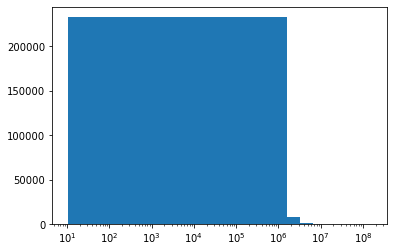

In [85]:
import matplotlib.pyplot as plt

lengths = []
for user_sum in train_sum:
    lengths += [np.sum(user_sum)]

_ = plt.hist(lengths, bins=100)
plt.xscale('log')

In [93]:
lengths = np.array(lengths)

lengths[lengths > 1e7].shape, lengths.shape


((192,), (243346,))

In [81]:
lengths

[70986.0,
 178746.0,
 375351.1599999999,
 375351.1599999999,
 550757.8400000001,
 608238.2,
 7220.6,
 20397.6,
 28668.6,
 50160.6,
 58801.6,
 69354.6,
 71402.6,
 79955.6,
 21116.92,
 21279.92,
 32645.459999999995,
 63864.409999999996,
 75951.41,
 100089.22,
 100089.22,
 116497.15,
 274452.26,
 284848.96,
 135763.25,
 337941.13,
 406726.06,
 456282.36,
 586807.51,
 596356.64,
 730242.91,
 833336.85,
 22585.190000000002,
 62027.67000000001,
 142629.80000000002,
 209952.97000000003,
 273572.43,
 281414.31000000006,
 470867.31999999995,
 526876.01,
 12803.1,
 19511.1,
 25797.079999999998,
 31992.08,
 44810.08,
 44810.08,
 58966.54,
 58966.54,
 89605.61,
 33071.0,
 154397.0,
 250902.91,
 275219.98,
 306298.37,
 335134.21,
 387828.20999999996,
 413094.20999999996,
 178491.94,
 233983.28,
 424555.6200000001,
 513336.0,
 513336.0,
 517137.0,
 943374.3488899999,
 1168429.15702,
 250571.47,
 364124.17000000004,
 379677.17000000004,
 392309.17000000004,
 436729.97,
 488992.97000000003,
 531155.47

In [77]:
categs = []
for user_sum in train_trans_type:
    categs.append(np.array(user_sum[PADDING_LEN:]))

In [78]:
categs

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1,
        1, 1, 1, 1, 2, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1,
        1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader

In [37]:
MERCH_TYPE_NCLASSES = len(mappings['merchant_type'])
TRANS_TYPE_NCLASSES = len(mappings['transaction_type_desc'])
PADDING_LEN = 300

In [39]:
class RSDataset(Dataset):
    def __init__(self, data_sum, data_trans_type, data_merchant_type, labels):
        super(RSDataset, self).__init__()
        self.data_sum = data_sum
        self.data_trans_type = data_trans_type
        self.data_merchant_type = data_merchant_type
        self.labels = labels

    def __len__(self):
        return len(self.data_sum)

    def __getitem__(self, idx):
        targets = np.zeros((MERCH_TYPE_NCLASSES - 1,), dtype=np.float32)
        for m in self.labels[idx]:
            if m:  # skip UNK, UNK-token should not be predicted
                targets[m - 1] = 1.0

        item = {
            "features": {},
            "targets": targets,
        }

        sum_feature = np.array(self.data_sum[idx][-PADDING_LEN:])
        sum_feature = np.vectorize(lambda s: np.log(1 + s))(sum_feature)
        if sum_feature.shape[0] < PADDING_LEN:
            pad = np.zeros(
                (PADDING_LEN - sum_feature.shape[0],), dtype=np.float32
            )
            sum_feature = np.hstack((sum_feature, pad))
        item["features"]["sum"] = torch.from_numpy(sum_feature).float()

        for feature_name, feature_values in zip(
            ["trans_type", "merchant_type"],
            [self.data_trans_type[idx], self.data_merchant_type[idx]],
        ):

            feature_values = np.array(feature_values[-PADDING_LEN:])
            mask = np.ones(feature_values.shape[0], dtype=np.float32)
            if feature_values.shape[0] < PADDING_LEN:
                feature_values = np.append(
                    feature_values,
                    np.zeros(
                        PADDING_LEN - feature_values.shape[0], dtype=np.int64
                    ),
                )
                mask = np.append(
                    mask,
                    np.zeros(PADDING_LEN - mask.shape[0], dtype=np.float32),
                )
            item["features"][feature_name] = torch.from_numpy(feature_values).long()
            item["features"][f"{feature_name}_mask"] = torch.from_numpy(mask).float()

        return item

In [40]:
train_dataset = RSDataset(
    train_sum, train_trans_type, train_merchant_type, train_labels
)
valid_dataset = RSDataset(
    valid_sum, valid_trans_type, valid_merchant_type, valid_labels
)


In [41]:
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=2
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=2
)

In [55]:
# sanity check
for i in tqdm(range(len(train_loader))):
    batch = next(iter(train_loader))
    print(batch['features'].keys())
    print(batch['features']['sum'].shape)
    print(batch['features']['sum'])
    print(batch['features']['trans_type'])
    print(batch['targets'].shape)
    
    print(batch['features']['trans_type'][0], batch['features']['trans_type_mask'][0])
    break

  0%|          | 0/3803 [00:00<?, ?it/s]

dict_keys(['sum', 'trans_type', 'trans_type_mask', 'merchant_type', 'merchant_type_mask'])
torch.Size([64, 300])
tensor([[ 3.6376,  7.3415,  5.8999,  ...,  0.0000,  0.0000,  0.0000],
        [ 5.4992,  4.8598,  4.7185,  ...,  0.0000,  0.0000,  0.0000],
        [ 5.3519, 10.5992,  8.3104,  ...,  5.4699,  6.0621,  5.3650],
        ...,
        [ 5.7419,  5.7589,  8.8598,  ...,  4.4054,  8.3121,  7.2011],
        [ 5.5796,  5.4116,  5.1240,  ...,  5.3181,  5.2040,  6.2126],
        [ 7.8800,  5.7301,  4.2946,  ...,  0.0000,  0.0000,  0.0000]])
tensor([[1, 3, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [2, 3, 3,  ..., 1, 1, 1],
        ...,
        [1, 1, 3,  ..., 1, 3, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [3, 1, 1,  ..., 0, 0, 0]])
torch.Size([64, 457])
tensor([1, 3, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Model

This is the baseline model for predicting purchases in `merchant_type` in the next 2 months

In [49]:
import torch.nn as nn
from collections import OrderedDict

In [98]:
params = {
    'merchant_type_emb_dim': 64,
    'trans_type_embedding': 3,
    'transformer_nhead': 4,
    'transformer_dim_feedforward': 256,
    'transformer_dropout': 0.2,
    'dense_unit': 256,
    'num_layers': 4,
}

In [99]:
MERCH_TYPE_NCLASSES, TRANS_TYPE_NCLASSES

(458, 5)

In [100]:
from torch.nn.modules.normalization import LayerNorm

In [101]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.merchant_type_embedding = nn.Embedding(
            MERCH_TYPE_NCLASSES, params["merchant_type_emb_dim"]
        )
        self.trans_type_embedding = nn.Embedding(
            TRANS_TYPE_NCLASSES, params["trans_type_embedding"]
        )

        embedding_size = (
            params["merchant_type_emb_dim"]
            + params["trans_type_embedding"]
            + 1
        )
        
        transformer_block = nn.TransformerEncoderLayer(d_model=embedding_size,
                                                        nhead=params["transformer_nhead"],
                                                        dim_feedforward=params["transformer_dim_feedforward"],
                                                        dropout=params["transformer_dropout"])
        self.transformer_encoder = nn.TransformerEncoder(transformer_block, 
                                                         params["num_layers"], 
                                                         LayerNorm(embedding_size))

        self.linear = nn.Linear(
            in_features=embedding_size, out_features=params["dense_unit"]
        )
        self.scorer = nn.Linear(
            in_features=params["dense_unit"],
            out_features=MERCH_TYPE_NCLASSES - 1,
        )

    def forward(self, features):

        merchant_type_emb = self.merchant_type_embedding(features["merchant_type"])
        trans_type_emb = self.trans_type_embedding(features["trans_type"])

        merchant_type_emb = merchant_type_emb * features["merchant_type_mask"].unsqueeze(-1)
        trans_type_emb = trans_type_emb * features["trans_type_mask"].unsqueeze(-1)

        embeddings = torch.cat(
            (merchant_type_emb, trans_type_emb, features["sum"].unsqueeze(-1)),
            dim=-1,
        )

        transformer_output = self.transformer_encoder(embeddings)
        pooling = torch.mean(transformer_output, dim=1)
        linear = torch.tanh(self.linear(pooling))
        merch_logits = self.scorer(linear)

        return merch_logits

### One-batch-check

In [102]:
model = Model()
criterion = nn.BCEWithLogitsLoss()
batch = next(iter(train_loader))
output = model(batch['features'])
loss = criterion(output, batch['targets'])
print(loss)

tensor(0.6975, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


## Train loop with [Catalyst](https://github.com/catalyst-team/catalyst)

[A comprehensive step-by-step guide to basic and advanced features](https://github.com/catalyst-team/catalyst#step-by-step-guide).

---



In [103]:
from catalyst import dl, utils
from catalyst.utils import metrics

## Custom metrics for this hackathon

In [104]:
from typing import List, Optional, Sequence, Tuple, Union

import numpy as np
import torch
from catalyst.utils.metrics.functional import preprocess_multi_label_metrics
from catalyst.utils.torch import get_activation_fn


def multi_label_metrics(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    threshold: Union[float, torch.Tensor],
    activation: Optional[str] = None,
    eps: float = 1e-7,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Computes multi-label precision for the specified activation and threshold.

    Args:
        outputs (torch.Tensor): NxK tensor that for each of the N examples
            indicates the probability of the example belonging to each of
            the K classes, according to the model.
        targets (torch.Tensor): binary NxK tensort that encodes which of the K
            classes are associated with the N-th input
            (eg: a row [0, 1, 0, 1] indicates that the example is
            associated with classes 2 and 4)
        threshold (float): threshold for for model output
        activation (str): activation to use for model output
        eps (float): epsilon to avoid zero division
    
    Extended version of 
        https://github.com/catalyst-team/catalyst/blob/master/catalyst/utils/metrics/accuracy.py#L58

    Returns:
        computed multi-label metrics
    """
    outputs, targets, _ = preprocess_multi_label_metrics(
        outputs=outputs, targets=targets
    )
    activation_fn = get_activation_fn(activation)
    outputs = activation_fn(outputs)

    outputs = (outputs > threshold).long()

    accuracy = (targets.long() == outputs.long()).sum().float() / np.prod(
        targets.shape
    )

    intersection = (outputs.long() * targets.long()).sum(axis=1).float()
    num_predicted = outputs.long().sum(axis=1).float()
    num_relevant = targets.long().sum(axis=1).float()
    union = num_predicted + num_relevant

    # Precision = ({predicted items} && {relevant items}) / {predicted items}
    precision = intersection / (num_predicted + eps * (num_predicted == 0))
    # Recall = ({predicted items} && {relevant items}) / {relevant items}
    recall = intersection / (num_relevant + eps * (num_relevant == 0))
    # IoU = ({predicted items} && {relevant items}) / ({predicted items} || {relevant items})
    iou = (intersection + eps * (union == 0)) / (union - intersection + eps)

    return accuracy, precision.mean(), recall.mean(), iou.mean()


def precision_at_k(
    actual: torch.Tensor, 
    predicted: torch.Tensor, 
    k: int,
):
    """
    Computes precision at cutoff k for one sample

    Args:
       actual: (torch.Tensor): tensor of length K with predicted item_ids sorted by relevance
       predicted (torch.Tensor): binary tensor that encodes which of the K
           classes are associated with the N-th input
           (eg: a row [0, 1, 0, 1] indicates that the example is
           associated with classes 2 and 4)
       k (int): parameter k of precison@k

    Returns:
       Computed value of precision@k for given sample
    """
    p_at_k = 0.0
    for item in predicted[:k]:
        if actual[item]:
            p_at_k += 1
    p_at_k /= k

    return p_at_k


def average_precision_at_k(
    actual: torch.Tensor, 
    predicted: torch.Tensor, 
    k: int,
) -> float:
    """
    Computes average precision at cutoff k for one sample

    Args:
      actual: (torch.Tensor): tensor of length K with predicted item_ids sorted by relevance
      predicted (torch.Tensor): binary tensor that encodes which of the K
          classes are associated with the N-th input
          (eg: a row [0, 1, 0, 1] indicates that the example is
          associated with classes 2 and 4)
      k (int): parameter k of AP@k

    Returns:
        Computed value of AP@k for given sample
    """
    ap_at_k = 0.0
    for idx, item in enumerate(predicted[:k]):
        if actual[item]:
            ap_at_k += precision_at_k(actual, predicted, k=idx + 1)
    ap_at_k /= min(k, actual.sum().cpu().numpy())
    

    return ap_at_k


def mean_average_precision_at_k(
    output: torch.Tensor, target: torch.Tensor, top_k: Tuple[int, ...] = (1,)
) -> List[float]:
    """
    Computes mean_average_precision_at_k at set of cutoff parameters K

    Args:
       outputs (torch.Tensor): NxK tensor that for each of the N examples
           indicates the probability of the example belonging to each of
           the K classes, according to the model.
       targets (torch.Tensor): binary NxK tensort that encodes which of the K
           classes are associated with the N-th input
           (eg: a row [0, 1, 0, 1] indicates that the example is
           associated with classes 2 and 4)
       top_k (tuple): list of parameters k at which map@k will be computed


    Returns:
       List of computed values of map@k at each cutoff k from topk
    """
    max_k = max(top_k)
    batch_size = target.size(0)

    _, top_indices = output.topk(k=max_k, dim=1, largest=True, sorted=True)

    result = []
    for k in top_k:  # loop over k
        map_at_k = 0.0
        for actual_target, predicted_items in zip(
            target, top_indices
        ):  # loop over samples
            map_at_k += average_precision_at_k(
                actual_target, predicted_items, k
            )
        map_at_k = map_at_k / batch_size
        result.append(map_at_k)

    return result

In [105]:
# What is Runner?
# https://catalyst-team.github.io/catalyst/api/core.html#runner
class CustomRunner(dl.Runner):

    def _handle_batch(self, batch):
        # model train/valid step
        features, targets = batch["features"], batch["targets"]
        logits = self.model(features)
        scores = torch.sigmoid(logits)

        loss = self.criterion(logits, targets)
        accuracy, precision, recall, iou = multi_label_metrics(
            logits, targets, threshold=0.5, activation="Sigmoid"
        )
        map05, map10, map20 = mean_average_precision_at_k(
            scores, targets, top_k=(5, 10, 20)
        )
        batch_metrics = {
            "loss": loss,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "iou": iou,
            "map05": map05,
            "map10": map10,
            "map20": map20
        }
        
        self.input = {"features": features, "targets": targets}
        self.output = {"logits": logits, "scores": scores}
        self.batch_metrics.update(batch_metrics)

        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
    
    def predict_batch(self, batch):
        # model inference step
        batch = utils.maybe_recursive_call(batch, "to", device=self.device)
        logits = self.model(batch["features"])
        scores = torch.sigmoid(logits)
        return scores

In [106]:
model = Model()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loaders = {"train": train_loader, "valid": valid_loader}

In [107]:
%load_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 501), started 1:55:12 ago. (Use '!kill 501' to kill it.)

In [ ]:
# For other minimal examples, please follow the link below
# https://github.com/catalyst-team/catalyst#minimal-examples
runner = CustomRunner()
# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=None,
    loaders=loaders,
    logdir="./logs",
    num_epochs=10,
    verbose=True,
    load_best_on_end=True,
    overfit=False,  #  <<<--- DO NOT FORGET TO MAKE IT ``False`` 
                    #  (``True`` uses only one batch to check pipeline correctness)
    callbacks=[
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
        # dl.AveragePrecisionCallback(input_key="targets", output_key="scores", prefix="ap"),
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
        # dl.AUCCallback(input_key="targets", output_key="scores", prefix="auc"),
    ],
    main_metric="iou", # "ap/mean", 
    minimize_metric=False,
)

1/10 * Epoch (train): 100% 3803/3803 [19:29<00:00,  3.25it/s, accuracy=0.978, iou=0.374, loss=0.062, map05=0.806, map10=0.690, map20=0.617, precision=0.780, recall=0.415]
1/10 * Epoch (valid): 100% 271/271 [01:09<00:00,  3.91it/s, accuracy=0.984, iou=0.349, loss=0.048, map05=0.689, map10=0.627, map20=0.612, precision=0.617, recall=0.516]
[2020-09-19 16:16:55,835] 
1/10 * Epoch 1 (train): accuracy=0.9793 | iou=0.2565 | loss=0.0612 | map05=0.6237 | map10=0.5533 | map20=0.5216 | precision=0.6791 | recall=0.3265
1/10 * Epoch 1 (valid): accuracy=0.9815 | iou=0.3253 | loss=0.0548 | map05=0.6831 | map10=0.6057 | map20=0.5706 | precision=0.6206 | recall=0.4774
2/10 * Epoch (train): 100% 3803/3803 [20:03<00:00,  3.16it/s, accuracy=0.985, iou=0.362, loss=0.045, map05=0.774, map10=0.717, map20=0.651, precision=0.779, recall=0.492]
2/10 * Epoch (valid): 100% 271/271 [01:11<00:00,  3.80it/s, accuracy=0.985, iou=0.346, loss=0.046, map05=0.732, map10=0.661, map20=0.643, precision=0.604, recall=0.519]

In [ ]:
# model inference example
# for prediction in runner.predict_loader(loader=loaders["valid"]):
#     assert prediction.detach().cpu().numpy().shape[-1] == MERCH_TYPE_NCLASSES-1

In [ ]:
# import plotly  # required for contrib
# from catalyst.contrib.utils import plot_tensorboard_log

# plot_tensorboard_log(logdir="./logs", step="batch")

In [ ]:
import plotly  # required for contrib
from catalyst.contrib.utils import plot_tensorboard_log

plot_tensorboard_log(
    logdir="./logs", 
    step="epoch", 
    metrics=[
        "loss", "accuracy", "precision", "recall", "iou", 
        "map05", "map10", "map20",
        "ap/mean", "auc/mean"
    ]
)

## Your task

We suggest you to improve this baseline. Feel free to use any kind of model architectures, loss functions, inputs, etc. in your experiments.


YOUR TASK is to predict purchases in `merchant_type` in **January-February 2020** for all the clients (50k) from the given dataset.

SUBMISSION FORMAT: You should submit a `.csv` file in the following format. 

The submission file should contain two columns:
* `party_rk` -- client unique identifier
* `recommendations` -- list of the **top 30** predicted `merchant_type`, sorted by predicted proba (pay attention!) **separated by commas**. 

The `.csv` file separator should be **semicolon (";")**. The submission file example can be generated by the pipeline shown below.

EVALUATION: Your submission will be evaluated by metric **MAP@30**. Scores for this part of the hackathon will be given according to the value of this metric.

Good luck!

## Submission file example

In [ ]:
# create data loader for submission
full_party = pd.read_csv(transactions_path, usecols=['party_rk']).party_rk.unique()
full_sum, full_trans_type, full_merchant_type, full_labels = prepare_data(
    full_party, mode="submission"
)
full_dataset = RSDataset(
   full_sum, full_trans_type, full_merchant_type, full_labels
)
full_loader = DataLoader(
    full_dataset, batch_size=64, shuffle=False, num_workers=8, drop_last=False)

In [ ]:
# get predictions from the model
predictions = []
for scores in tqdm(runner.predict_loader(loader=full_loader), total = len(full_loader)):
    _, top_indices = scores.topk(k=30, dim=1, largest=True, sorted=True)
    top_indices += 1
    predictions += top_indices.detach().cpu().tolist()

In [ ]:
# inverse mapping for merchant_type in predictions
merchant_type_inverse_mapping = {k: v for v, k in mappings['merchant_type'].items()}
def inverse_mapping(x):
    return list(map(merchant_type_inverse_mapping.get, x))

predictions = list(map(inverse_mapping, predictions))

In [ ]:
# create submission table
submission = pd.DataFrame({
    "party_rk" : full_party, 
    "recommendations" : predictions
})
submission['recommendations'] = submission['recommendations'].apply(lambda x: ",".join(map(str, x)))

submission.to_csv('submission_[TEAM_NAME].csv', index=False, sep=";")